In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import networkx as nx
import re

In [44]:
#!pip install proj
#!pip install geopandas
#!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 2.3 MB/s eta 0:00:0000:0100:01


In [9]:
#CA food banks

food_ca = pd.read_csv("data/food_ca.csv")
food_ca.head()

,Name,Street Address,City,State,Zip Code,County,Phone,Description,Resource Type,Web Link,Notes,Latitude,Longitude
0,Agnes Memorial Church Of God In Christ,2372 International Boulevard,Oakland,CA,94601,Alameda,510-533-1101,Partners with the City of Oakland's Hunger Rel...,Food Pantry,http://agnesmemorialchurch.com,NaN,37.783047,-122.234238
1,Alameda County Community Food Bank,7900 Edgewater Drive,Oakland,CA,94621,Alameda,510-635-3663,Call our Helpline at: 1-800-870-FOOD (3663) or...,Food Bank,https://www.accfb.org/,NaN,37.741538,-122.201300
2,Salaam Food Pantry,4039 Irvington Avenue,Fremont,CA,94538,Alameda,415-860-2409,Provides non-perishable grocery bags for needy...,Food Pantry,http://salaamfoodpantry.org/,NaN,37.531391,-121.959689
3,Sierra Winds,10354 Argonaut Lane,Jackson,CA,95642,Amador,NaN,"Monday through Friday Lunch at Noon, (must att...",Food Pantry,http://www.feedamador.org/site/pages/get_help.cgi,NaN,38.358841,-120.789164
4,St Patrick's Hall,115 Court St,Jackson,CA,95642,Amador,NaN,"Thursday evenings, 5:00-7:00pm",Food Pantry,http://www.feedamador.org/site/pages/get_help.cgi,NaN,38.349870,-120.773385


In [15]:
#shelters are PA?
shelter_pa = pd.read_csv("data/shelter_service.csv")
shelter_pa.head()

,_id,service_name,program_or_facility,neighborhood,address,latitude,longitude,organization,category,recommended_for,requirements,phone,narrative,schedule,holiday_exception
0,1,412 Youth Zone,412 Youth Zone,Downtown,"304 Wood St, 6th Floor, PA, 15219",40.438983,-80.001358,Auberle,roof-daytime,"unaccompanied youth, youth aging out of foster...","must be 16 - 23; and after first visit, become...",412-902-4068,"A safe place Downtown with a leisure space, ki...",Mon - Thurs: 11am - 7pm; Fri: 11am - 5pm; Sa...,NaN
1,2,Dinner & food anytime as needed - 412 Youth Zone,412 Youth Zone,Downtown,"304 Wood St, 6th Floor, PA, 15219",40.438983,-80.001358,Auberle,meals,"unaccompanied youth, youth aging out of foster...","must be 16 - 23; and after first visit, become...",412-902-4068,"Food available throughout day as needed, Dinne...",Mon - Thurs: 11am - 7pm ; Fri: 11am - 5pm ; ...,NaN
2,3,412 Youth Zone - Physician's Assistant/Registe...,412 Youth Zone,Downtown,"304 Wood St, 6th Floor, PA, 15219",40.438983,-80.001358,Auberle,health,NaN,must be 16 - 23,412-902-4068,"A UPMC physician's assistant, registered nurse...",Mon - Thu: 11am - 4pm,NaN
3,4,Veterans Place,Veterans Place of Washington Blvd,Larimer,"945 Washington Blvd, PA, 15206",40.461178,-79.906674,Veterans Place,roof-daytime|finances,NaN,DD214 or Military ID required for services,412-363-0500,Veterans Place is not just a great place to ha...,Mon - Fri: 8am - 3pm,NaN
4,5,"Meals, Pantry, Laundry - Veterans Place",Veterans Place of Washington Blvd,Larimer,"945 Washington Blvd, PA, 15206",40.461178,-79.906674,Veterans Place,meals|pantries-supplies,Veterans,for Vets only,412-363-0500,Great hangout space with breakfast at 8am - 9a...,Mon - Fri: 8am - 9am breakfast; Mon - Fri: ...,NaN


In [17]:
#may be british columbia??
food_banks = pd.read_csv("data/food_banks.csv")
food_banks.head()

,FCLTY_NM,KEYWORDS,ST_ADDRESS,LOCALITY,MAIL_ADD,POSTAL_CD,WEBSITE,IMAGE_URL,LATITUDE,LONGITUDE,...,GEOCD_IND,SRCDATA_ID,CUST_ORG,BUS_CAT_CL,BUS_CAT_DS,OCCPNT_TYP,SHAPE,SEQ_ID,X,Y
0,Castlegar Community Harvest Food Bank,Food; Food Bank,614 Christina Pl,Castlegar,C/O 301 - 32nd Street,V1N 3S6,NaN,NaN,49.309704,-117.659160,...,NaN,180,"Ministry of Forest, Lands and Natural Resource...",healthCareAndSocialAssistance,Health care and social assistance,Health care and social assistance,NaN,180,1605641.442,512760.333
1,Prince Rupert Salvation Army Family Services,Food; Food Bank,NaN,Prince Rupert,25 Grenville Court,V8J 1R3,NaN,NaN,54.310505,-130.326320,...,NaN,160,"Ministry of Forest, Lands and Natural Resource...",healthCareAndSocialAssistance,Health care and social assistance,Health care and social assistance,NaN,160,719359.855,1042844.829
2,St. Mark's Food Bank,Food; Food Bank,NaN,Dawson Creek,1029 103 Avenue,V1G 2G6,NaN,NaN,55.757946,-120.231682,...,NaN,179,"Ministry of Forest, Lands and Natural Resource...",healthCareAndSocialAssistance,Health care and social assistance,Health care and social assistance,NaN,179,1360848.336,1210542.427
3,Richmond Food Bank Society,Food; Food Bank,NaN,Richmond,100-5800 Cedarbridge Way,V6X 2A7,http://richmondfoodbank.org/,NaN,49.173008,-123.142021,...,NaN,163,"Ministry of Forest, Lands and Natural Resource...",healthCareAndSocialAssistance,Health care and social assistance,Health care and social assistance,NaN,163,1208559.735,466062.508
4,Surrey Food Bank,Food; Food Bank,10732 City Parkway,Surrey,10732 City Parkway,V3T 4C7,https://www.surreyfoodbank.org/,NaN,49.197814,-122.848643,...,NaN,144,"Ministry of Forest, Lands and Natural Resource...",healthCareAndSocialAssistance,Health care and social assistance,Health care and social assistance,NaN,144,1229832.739,469724.298


## California File EDA

In [42]:
food_ca.columns

Index(['Name', 'Street Address', 'City', 'State', 'Zip Code', 'County',
       'Phone', 'Description', 'Resource Type', 'Web Link', 'Notes',
       'Latitude', 'Longitude'],
      dtype='object')

In [93]:
#missing tons of notes -- good amount of weblinks (maybe scrape?)
food_ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            1852 non-null   object 
 1   Street Address  1852 non-null   object 
 2   City            1849 non-null   object 
 3   State           1851 non-null   object 
 4   Zip Code        1852 non-null   int64  
 5   County          1852 non-null   object 
 6   Phone           1478 non-null   object 
 7   Description     1746 non-null   object 
 8   Resource Type   1852 non-null   object 
 9   Web Link        1843 non-null   object 
 10  Notes           44 non-null     object 
 11  Latitude        1852 non-null   float64
 12  Longitude       1852 non-null   float64
 13  Open_Weekend    1852 non-null   int64  
 14  Has_Groceries   1852 non-null   int64  
 15  Open_Weekday    1852 non-null   int64  
 16  Open_Morning    1746 non-null   object 
dtypes: float64(2), int64(4), object(1

In [24]:
#Most resources are related to food and nutrition
food_ca['Resource Type'].value_counts(normalize=True)

Resource Type
Food Pantry                    0.779158
Nutrition Services Program     0.058315
Food Distribution Program      0.057235
Food Bank                      0.039417
Emergency Food Assistance      0.038877
USDA Commodity Program         0.024298
Mobile Food Pantry             0.001620
Emergency Food Distribution    0.000540
Senior Food Box                0.000540
Name: proportion, dtype: float64

In [26]:
#More detailed about services maybe need to create features 
food_ca['Description']

0       Partners with the City of Oakland's Hunger Rel...
1       Call our Helpline at: 1-800-870-FOOD (3663) or...
2       Provides non-perishable grocery bags for needy...
3       Monday through Friday Lunch at Noon, (must att...
4                          Thursday evenings, 5:00-7:00pm
                              ...                        
1847    To create a path away from homelessness and to...
1848                                          Thurs 1-3pm
1849    FREED provides peer-delivered independent livi...
1850    Serves as a community-centered provider of ser...
1851    Helping area seniors to obtain their legal rig...
Name: Description, Length: 1852, dtype: object

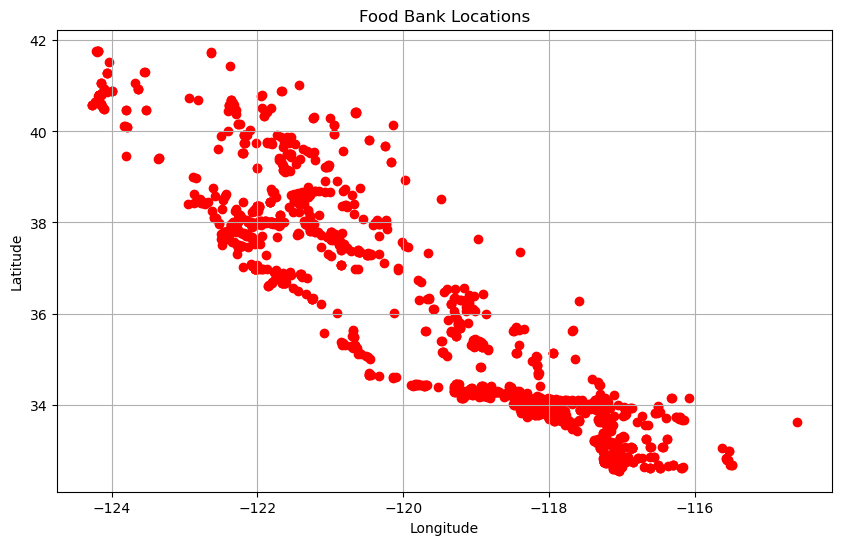

In [36]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(food_ca['Longitude'], food_ca['Latitude'], color='red')
plt.title('Food Bank Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

## Feature Engineering 

In [77]:
#weekends

def is_open_on_weekend(description):
    # Check if the description is a string
    if isinstance(description, str):
        # Convert description to lowercase
        description = description.lower()
        # Check for keywords indicating weekend opening
        if 'saturday' in description or 'sunday' in description:
            return 1
    return 0

# Create the binary feature
food_ca['Open_Weekend'] = food_ca['Description'].apply(is_open_on_weekend)
food_ca['Open_Weekend'].value_counts()

Open_Weekend
0    1729
1     123
Name: count, dtype: int64

In [85]:
#weekday

def is_open_on_weekday(description):
    # Check if the description is a string
    if isinstance(description, str):
        # Convert description to lowercase
        description = description.lower()
        # Check for keywords indicating weekend opening
        if 'monday' in description or 'tuesday' in description or 'wednesday' in description or 'thursday' in description or 'friday' in description:
            return 1
    return 0

# Create the binary feature
food_ca['Open_Weekday'] = food_ca['Description'].apply(is_open_on_weekday)
food_ca['Open_Weekday'].value_counts()

Open_Weekday
0    1179
1     673
Name: count, dtype: int64

In [91]:
#morning 

def is_open_in_morning(description):
    # Check if the description is a string
    if isinstance(description, str):
        # Convert description to lowercase
        description = description.lower()
        if 'am' in description:
            return 'morning'
        elif 'pm' in description:
            return 'afternoon/evening'
        else:
            return 'TBD'

# Create the binary feature
food_ca['Open_Morning'] = food_ca['Description'].apply(is_open_in_morning)
food_ca['Open_Morning'].value_counts()

Open_Morning
morning              972
TBD                  540
afternoon/evening    234
Name: count, dtype: int64

In [101]:
# Function to extract opening hours
def extract_opening_hours(description):
    if not isinstance(description, str):
        return None  # Return None for non-string values

    # Define regex patterns for different time formats with unique group names
    patterns = [
        r'(?P<day1>\b(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)\b)\s*(?P<time1>\d{1,2}:\d{2}\s*[APMapm]{2}\s*-\s*\d{1,2}:\d{2}\s*[APMapm]{2})',
        r'(?P<day2>\b(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)\b)\s*(?P<time2>\d{1,2}\s*[APMapm]{2}\s*-\s*\d{1,2}\s*[APMapm]{2})',
        r'Open from\s*(?P<time3>\d{1,2}\s*[APMapm]{2})\s*to\s*(?P<time4>\d{1,2}\s*[APMapm]{2})',
        r'Open daily\s*(?P<time5>\d{1,2}:\d{2}\s*[APMapm]{2})\s*-\s*(?P<time6>\d{1,2}:\d{2}\s*[APMapm]{2})'
    ]

    # Search for patterns in the description
    for pattern in patterns:
        match = re.search(pattern, description)
        if match:
            return match.group(0)  # Return the matched opening hours

    return None  # Return None if no pattern matches

# Apply the function to the DataFrame
food_ca['Hours_Opened'] = food_ca['Description'].apply(extract_opening_hours)


In [109]:
#Function to extract shelter's "audience"

# Function to extract available audience
def extract_available_to(description):
    if not isinstance(description, str):
        return None  # Return None for non-string values

    available_to = []
    
    # Check for keywords and append to the list
    if 'income' in description.lower():
        available_to.append('Income Requirements')
    if 'seni' in description.lower():
        available_to.append('Seniors')
    if 'family' in description.lower() or 'children' in description.lower() or 'youth' in description.lower():
        available_to.append('Family/Children')

    # Join the list into a single string
    return ', '.join(available_to) if available_to else None

# Apply the function to create the "Available To" column
food_ca['Available_To'] = food_ca['Description'].apply(extract_available_to)

In [111]:
food_ca['Available_To'].value_counts()

Available_To
Income Requirements                              203
Seniors                                           57
Income Requirements, Seniors                      57
Family/Children                                   54
Income Requirements, Family/Children               7
Seniors, Family/Children                           7
Income Requirements, Seniors, Family/Children      3
Name: count, dtype: int64

In [115]:
food_ca.columns

Index(['Name', 'Street Address', 'City', 'State', 'Zip Code', 'County',
       'Phone', 'Description', 'Resource Type', 'Web Link', 'Notes',
       'Latitude', 'Longitude', 'Open_Weekend', 'Has_Groceries',
       'Open_Weekday', 'Open_Morning', 'Hours_Opened', 'Available_To'],
      dtype='object')

In [113]:
food_ca.head()

,Name,Street Address,City,State,Zip Code,County,Phone,Description,Resource Type,Web Link,Notes,Latitude,Longitude,Open_Weekend,Has_Groceries,Open_Weekday,Open_Morning,Hours_Opened,Available_To
0,Agnes Memorial Church Of God In Christ,2372 International Boulevard,Oakland,CA,94601,Alameda,510-533-1101,Partners with the City of Oakland's Hunger Rel...,Food Pantry,http://agnesmemorialchurch.com,NaN,37.783047,-122.234238,0,0,0,morning,None,None
1,Alameda County Community Food Bank,7900 Edgewater Drive,Oakland,CA,94621,Alameda,510-635-3663,Call our Helpline at: 1-800-870-FOOD (3663) or...,Food Bank,https://www.accfb.org/,NaN,37.741538,-122.201300,0,1,1,morning,None,None
2,Salaam Food Pantry,4039 Irvington Avenue,Fremont,CA,94538,Alameda,415-860-2409,Provides non-perishable grocery bags for needy...,Food Pantry,http://salaamfoodpantry.org/,NaN,37.531391,-121.959689,0,1,0,morning,None,None
3,Sierra Winds,10354 Argonaut Lane,Jackson,CA,95642,Amador,NaN,"Monday through Friday Lunch at Noon, (must att...",Food Pantry,http://www.feedamador.org/site/pages/get_help.cgi,NaN,38.358841,-120.789164,0,0,1,TBD,None,None
4,St Patrick's Hall,115 Court St,Jackson,CA,95642,Amador,NaN,"Thursday evenings, 5:00-7:00pm",Food Pantry,http://www.feedamador.org/site/pages/get_help.cgi,NaN,38.349870,-120.773385,0,0,1,afternoon/evening,None,None


In [118]:
#food_ca.to_csv('food_banks.csv', index=False)  # Set index=False to avoid writing row indices

## Playground -- Learning Knowledge Graphs

In [52]:
# Connect to Neo4j
uri = "bolt://localhost:7687"  # Adjust if necessary
driver = GraphDatabase.driver(uri, auth=("neo4j", "KnowHax123"))  # Replace with your credentials

def create_knowledge_graph(tx, name, resource_type, street, city, state, zip_code, county, phone, description, web_link):
    # Create Food Bank node
    tx.run("CREATE (f:FoodBank {name: $name, street: $street, city: $city, state: $state, zip: $zip, county: $county, phone: $phone, description: $description, web_link: $web_link})",
           name=name, street=street, city=city, state=state, zip=zip_code, county=county, phone=phone, description=description, web_link=web_link)
    
    # Create Resource Type node and relationship
    tx.run("MERGE (r:ResourceType {type: $resource_type}) "
           "MERGE (f:FoodBank {name: $name}) "
           "MERGE (f)-[:PROVIDES]->(r)",
           resource_type=resource_type, name=name)

# Create nodes and relationships
with driver.session() as session:
    for index, row in food_ca.iterrows():
        session.write_transaction(create_knowledge_graph, 
                                  row['Name'], 
                                  row['Resource Type'], 
                                  row['Street Address'], 
                                  row['City'], 
                                  row['State'], 
                                  row['Zip Code'], 
                                  row['County'], 
                                  row['Phone'], 
                                  row['Description'], 
                                  row['Web Link'])

/var/folders/q0/q0rxxdr90k33s6_gybr4yswc0000gp/T/ipykernel_96165/3014952929.py:19: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_knowledge_graph,


AuthError: {code: Neo.ClientError.Security.Unauthorized} {message: The client is unauthorized due to authentication failure.}

## Playground -- Learning Knowledge Graphs

In [55]:
# Connect to Neo4j
uri = "bolt://localhost:7687"  # Adjust if necessary
driver = GraphDatabase.driver(uri, auth=("neo4j", "jellyknowhax"))  # Replace with your credentials

def create_knowledge_graph(tx, name, resource_type, street, city, state, zip_code, county, phone, description, web_link):
    # Create Food Bank node
    tx.run("CREATE (f:FoodBank {name: $name, street: $street, city: $city, state: $state, zip: $zip, county: $county, phone: $phone, description: $description, web_link: $web_link})",
           name=name, street=street, city=city, state=state, zip=zip_code, county=county, phone=phone, description=description, web_link=web_link)
    
    # Create Resource Type node and relationship
    tx.run("MERGE (r:ResourceType {type: $resource_type}) "
           "MERGE (f:FoodBank {name: $name}) "
           "MERGE (f)-[:PROVIDES]->(r)",
           resource_type=resource_type, name=name)

# Create nodes and relationships
with driver.session() as session:
    for index, row in food_ca.iterrows():
        session.execute_write(create_knowledge_graph, 
                                  row['Name'], 
                                  row['Resource Type'], 
                                  row['Street Address'], 
                                  row['City'], 
                                  row['State'], 
                                  row['Zip Code'], 
                                  row['County'], 
                                  row['Phone'], 
                                  row['Description'], 
                                  row['Web Link'])

/var/folders/q0/q0rxxdr90k33s6_gybr4yswc0000gp/T/ipykernel_96165/2374490804.py:13: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


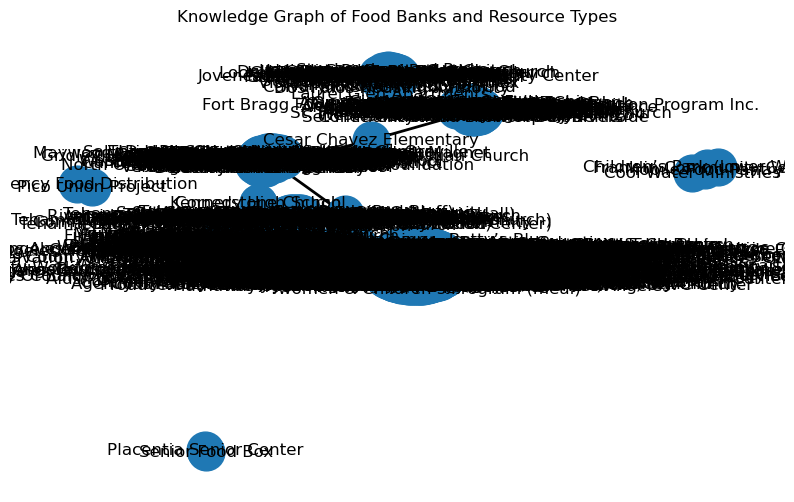

In [65]:
def fetch_graph_data(tx):
    # Fetch nodes and relationships
    query = """
    MATCH (f:FoodBank)-[:PROVIDES]->(r:ResourceType)
    RETURN f.name AS food_bank, r.type AS resource_type
    """
    return list(tx.run(query))  # Convert the result to a list

# Create a graph
G = nx.Graph()

# Retrieve data and add to the graph
with driver.session() as session:
    result = session.execute_read(fetch_graph_data)
    for record in result:
        G.add_node(record['food_bank'], label='Food Bank')
        G.add_node(record['resource_type'], label='Resource Type')
        G.add_edge(record['food_bank'], record['resource_type'])

# Close the driver
driver.close()

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Display the graph
plt.title("Knowledge Graph of Food Banks and Resource Types")
plt.axis('off')  # Turn off the axis
plt.show()